MASSACHUSETTS INSTITUTE OF TECHNOLOGY<br>
SYSTEM DESIGN & MANAGEMENT<br>
Author: R. Chadwick Holmes<br>
Date: June 5, 2021<br>
Last Update: December 10, 2021<br><br>

**Label: Final Workflow, Script 5**<br>

Script Purpose:<br>
Script for exploring supervised learning applied to the data set and the impact of uncertainties. This script focuses on a fully-connected neural network and 
bayesian neural network approach.
<br><br>


## Set environment

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
#!apt update
#!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirement
!pip install descartes cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install tensorflow==2.5.0
!pip install tensorflow_probability==0.13.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 2s (956 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%

In [ ]:
# libraries for plotting maps
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# libraries for tensorflow and tensorflow probability
import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tfd = tfp.distributions
tfpl = tfp.layers
tf.keras.backend.set_floatx('float64')
print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

# scikit helper functions
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics

# general libraries
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns

import statsmodels.api as sm
from scipy import stats
from pathlib import Path
import pickle as pkl

TF version: 2.5.0
TFP version: 0.13.0


### Set seed for randomized elements in script

In [ ]:
seed = 43

# define extent for mapping
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
extent = [xmin,xmax,ymin,ymax]

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/Colab Notebooks/Data'

Mounted at /content/drive


### Load data from saved pickle file

In [ ]:
datafolder = Path(path) 

#with open(datafolder/ "wells_shared.pkl","rb") as handle: 
#with open(datafolder/ "wellsp4_shared.pkl","rb") as handle: 
with open(datafolder/ "wellsp8_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
    
# unpack
fulldf = datadict['data']
coords = datadict['coords']
X_train = datadict['X_train'].reset_index(drop=True)
X_val   = datadict['X_val'].reset_index(drop=True)
X_test  = datadict['X_test'].reset_index(drop=True)
yr_train = datadict['yr_train'].reset_index(drop=True)
yr_val   = datadict['yr_val'].reset_index(drop=True)
yr_test  = datadict['yr_test'].reset_index(drop=True)
yc_train = datadict['yc_train'].reset_index(drop=True)
yc_val   = datadict['yc_val'].reset_index(drop=True)
yc_test  = datadict['yc_test'].reset_index(drop=True)
yc_oh_train = datadict['yc_oh_train']
yc_oh_val  = datadict['yc_oh_val']
yc_oh_test  = datadict['yc_oh_test']

In [ ]:
myprojection = ccrs.PlateCarree()

def createBasemap():
    expl_area = datafolder / 'Exploration_area.shp'
    expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

    rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
    #stamen_terrain = cimgt.Stamen('terrain-background')

    # generate plot of NM with river and stock image
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=myprojection)

    # Add the Stamen data at zoom level 9.
    ax.stock_img()
    #ax.add_image(stamen_terrain, 9)
    
    ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    ax.add_feature(expl_area_feat, facecolor='None', edgecolor='r', linewidth=2, alpha = 0.5)

    ax.set_extent(extent,crs=myprojection)
    ax.gridlines(crs = myprojection, draw_labels=True,
                 linewidth=0.5, color='k', alpha=0.25, linestyle='-')
    return ax

### Test that plotting works

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


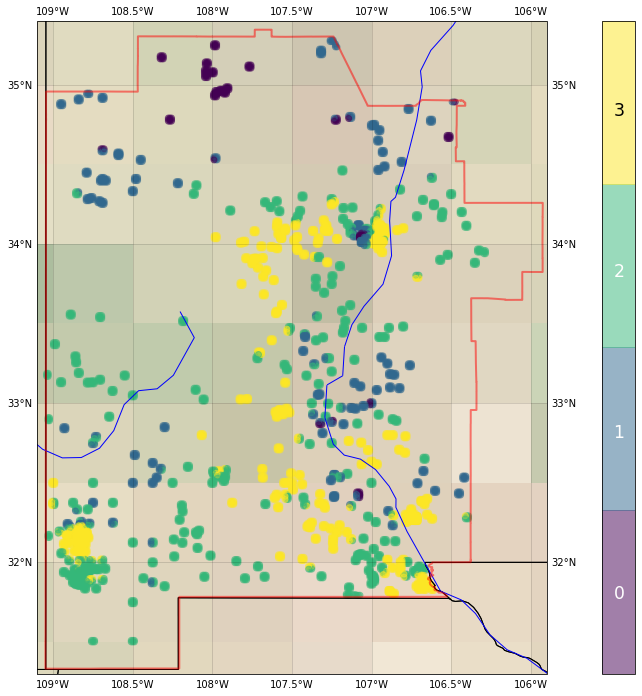

In [ ]:
ax = createBasemap();
colmap=plt.cm.get_cmap('viridis', 4)
gdf = gpd.GeoDataFrame(fulldf.copy(deep=True), 
                       geometry=gpd.points_from_xy(coords.Longitude, coords.Latitude),
                       crs = {'init': 'epsg:4326'})
pc = ax.scatter(coords.Longitude,
                coords.Latitude,
                cmap=colmap,
                c=pd.cut(gdf['GeothermGrad'],bins=[-999,30,40,60,999],right=False,labels=False),
                alpha=0.5,
                transform=myprojection);
cbar = plt.colorbar(pc);
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
  if(j==3):
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
              fontsize='xx-large',fontweight='extra bold')
  else:
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                fontsize='xx-large',fontweight='extra bold')

### Plot Prep

In [ ]:
## Set Plotting Parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### TensorFlow Time
#### https://www.coursera.org/learn/probabilistic-deep-learning-with-tensorflow2 


### Data Prep

In [ ]:
code2label = {0: 'Ultralow Gradient', 1: 'Low Gradient', 2: 'Medium Gradient', 3: 'High Gradient'}

In [ ]:
X_test.columns

Index(['DEM', 'DEMGrad', 'Gravity', 'GravityGrad', 'Magnetic', 'MagneticGrad',
       'DosageRate', 'WTDepth', 'WTGrad', 'BasementDepth', 'CrustalThickness',
       'AirTemperature', 'Precipitation', 'StrainRate', 'QFaults',
       'StateFaults', 'Drainage', 'VolcanicDikes', 'SiGeothermometry',
       'Lithium', 'Boron', 'HeatFlow', 'Earthquakes', 'Vents', 'Springs',
       'GeothermGrad_2class'],
      dtype='object')

In [ ]:
n_samples = fulldf.shape[0]
ntrain = int(0.70*n_samples)
nval   = int(0.15*n_samples)

# drop columns already determined to be colinear or are predicted variables
dropcols = ['AirTemperature','GeothermGrad','GeothermGrad_2class','GeothermGrad_4class']
print(dropcols)

fulldf['GradientCode'] = fulldf.GeothermGrad_4class.cat.codes
outcols = ['GradientCode']
incols =  set(fulldf.columns)-set(dropcols)-set(outcols)

Xtr = X_train[incols]
Xvl = X_val[incols]
Xts = X_test[incols]

# 4-class model
yc_val4   = yc_val['GeothermGrad_4class'].cat.codes
yc_test4  = yc_test['GeothermGrad_4class'].cat.codes
yc_train4 = yc_train['GeothermGrad_4class'].cat.codes

['AirTemperature', 'GeothermGrad', 'GeothermGrad_2class', 'GeothermGrad_4class']


In [ ]:
## scale and transform data (use both to avoid bug in scikit)
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)
pl = Pipeline(steps=[('scale',sc),('powertransform',pt)])

colnames = list(Xtr.columns)
pl.fit(Xtr, yc_train)
Xtrsc = pd.DataFrame(pl.transform(Xtr), columns=colnames)
Xvlsc = pd.DataFrame(pl.transform(Xvl), columns=colnames)
Xtssc = pd.DataFrame(pl.transform(Xts), columns=colnames)

# encode classification variable
le = LabelEncoder()
le.fit(yc_train4)
yenc_trn = le.transform(yc_train4)
yenc_val = le.transform(yc_val4)
yenc_tst = le.transform(yc_test4)

Xtrvl = pd.concat([Xtr[colnames],Xvl[colnames]]).reset_index(drop=True)
Xtrnvalsc=pd.concat([Xtrsc[colnames],Xvlsc[colnames]]).reset_index(drop=True)
yenc_trnval=np.append(yenc_trn,yenc_val)
yc_oh_trnval=np.vstack((yc_oh_train,yc_oh_val))

In [ ]:
print('train:')
counter = Counter(yc_train4)
for k,v in counter.items():
	per = v / len(yc_train4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
print('\nvalidate:')
counter = Counter(yc_val4)
for k,v in counter.items():
	per = v / len(yc_val4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

print('\ntest:')
counter = Counter(yc_test4)
for k,v in counter.items():
	per = v / len(yc_test4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

#print(list(Xtr))

train:
Class=3, n=1558 (41.658%)
Class=2, n=1420 (37.968%)
Class=0, n=129 (3.449%)
Class=1, n=633 (16.925%)

validate:
Class=0, n=27 (3.367%)
Class=2, n=305 (38.030%)
Class=1, n=136 (16.958%)
Class=3, n=334 (41.646%)

test:
Class=2, n=304 (37.905%)
Class=1, n=136 (16.958%)
Class=3, n=334 (41.646%)
Class=0, n=28 (3.491%)


### following Jason Brownlee's posts for setting up NN
####https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib as mpl

n_batches = 10
n_samples = fulldf.shape[0]
batch_size = int(np.floor(n_samples/n_batches))
loss_function = categorical_crossentropy
n_epochs = 100
verbosity = 1
num_folds = 10

learning_rate = 0.001
weight_reg = 1e-4
drop_rate = 0.2

### Tuning Learning Rate

### Tune on 
1. learning rate
2. weight regularization
3. drop rate
4. batch size

Stratified k-Fold CV discussed here:
https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/



In [ ]:
auc_cv_vals = []
loss_cv_vals = []
param_rng = [.001, .005, .010, .015, .025, .05]
for lr in param_rng:

  print(f"****Trying parameter value: {lr}****")

  # Define per-fold score containers
  auc_per_fold = []
  loss_per_fold = []

  optimizer = Adam(learning_rate = lr)

  # maintain stratified sampling
  kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=1, random_state=seed)

  # Stratified K-fold Cross Validation model evaluation
  fold_no = 1

  for train, test in kfold.split(Xtrnvalsc, yenc_trnval):

    # Define model architecture
    model = tfk.Sequential([
        tfk.layers.Dense(len(incols), 
                        activation="relu", 
                        use_bias=True,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(weight_reg),
                        input_shape=(len(incols),), 
                        name="dense_1"),
        tfk.layers.Dropout(drop_rate, name="dropout_1"),
        tfk.layers.Dense(len(incols),
                        activation="relu",
                        use_bias=True,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(weight_reg),
                        name="dense_2"),
        tfk.layers.Dropout(drop_rate, name="dropout_2"),
        tfk.layers.Dense(len(code2label), activation='softmax', name="output") # Output layer
      ], name="model")
    
    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss=loss_function,
                  metrics=tfk.metrics.AUC(curve='ROC', multi_label=False))
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.fit(x=Xtrnvalsc.iloc[train,:],
                        y=yc_oh_trnval[train],
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_data=(Xvlsc,yc_oh_val),
                        verbose=verbosity)
    
    # Generate generalization metrics
    scores = model.evaluate(Xtrnvalsc.iloc[test,:], yc_oh_trnval[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    auc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
  # Provide average scores
  auc_cv_vals.append(np.mean(auc_per_fold))
  loss_cv_vals.append(np.mean(loss_per_fold))


Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 17ms/step - loss: 0.3572 - auc_35: 0.9806 - val_loss: 0.2469 - val_auc_35: 0.9931
Epoch 39/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3585 - auc_35: 0.9804 - val_loss: 0.2406 - val_auc_35: 0.9933
Epoch 40/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3541 - auc_35: 0.9808 - val_loss: 0.2526 - val_auc_35: 0.9923
Epoch 41/100
8/8 [==============================] - 0s 17ms/step - loss: 0.3461 - auc_35: 0.9820 - val_loss: 0.2465 - val_auc_35: 0.9927
Epoch 42/100
8/8 [==============================] - 0s 17ms/step - loss: 0.3629 - auc_35: 0.9801 - val_loss: 0.2642 - val_auc_35: 0.9913
Epoch 43/100
8/8 [==============================] - 0s 17ms/step - loss: 0.3623 - auc_35: 0.9801 - val_loss: 0.2534 - val_auc_35: 0.9922
Epoch 44/100
8/8 [==============================] - 0s 18ms/step - loss: 0.3776 - auc_35: 0.9778 - val_loss: 0.2584 - val_auc_35: 0.9917
Epo

[98.21663635556541, 99.14510510726647, 99.20277094868655, 99.18192118541546, 98.98730697358269, 91.16456456250468] [0.34249647586128784, 0.23720547421366606, 0.23549477905690325, 0.23976599472507668, 0.27174377659744503, 0.6340714646188064]
    vals        auc      loss
0  0.001  98.216636  0.342496
1  0.005  99.145105  0.237205
2  0.010  99.202771  0.235495
3  0.015  99.181921  0.239766
4  0.025  98.987307  0.271744
5  0.050  91.164565  0.634071


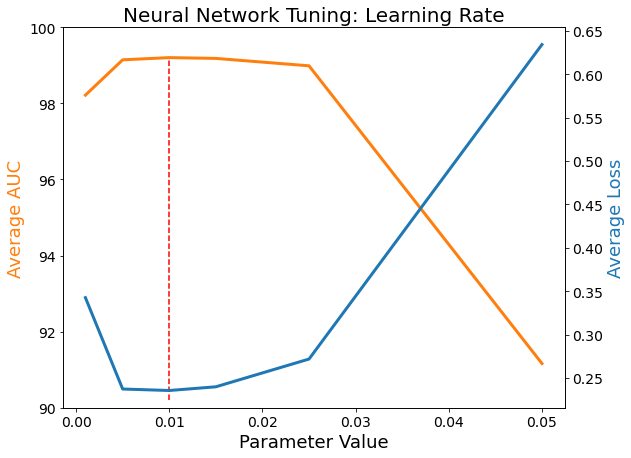

In [ ]:
print(auc_cv_vals, loss_cv_vals)
results = pd.DataFrame({'vals':param_rng,'auc':auc_cv_vals,'loss': loss_cv_vals})
print(results)
#results = results.iloc[1:-1,:]
with mpl.style.context('seaborn-muted'):
  fig, ax1 = plt.subplots(figsize=(9,7))
  ax1.plot(results.vals, results.auc,
           lw=3, c='#FF7F0E', label='AUC')
  ax2 = ax1.twinx()
  ax2.plot(results.vals, results.loss,
           lw=3, color='#1F77B4', label='AUC')
  ax1.set_xlabel('Parameter Value');
  ax1.set_ylabel('Average AUC', color='#FF7F0E')
  ax2.set_ylabel('Average Loss',color='#1F77B4')
  ax1.vlines(0.01, ymin=90.2, ymax=max(results.auc),
             linestyles='dashed',colors='r')
  ax1.set_ylim([90,100])
  plt.title('Neural Network Tuning: Learning Rate');

### Tuning Weight Regularization

In [ ]:
# WDS8
learning_rate = 0.01

In [ ]:
auc_cv_vals = []
loss_cv_vals = []
param_rng = [5e-5,7.5e-5,1e-4,2e-4,3e-4,5e-4]
for wr in param_rng:

  print(f"****Trying parameter value: {wr}****")

  # Define per-fold score containers
  auc_per_fold = []
  loss_per_fold = []

  optimizer = Adam(learning_rate = learning_rate)

  # maintain stratified sampling
  kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=3, random_state=seed)

  # Stratified K-fold Cross Validation model evaluation
  fold_no = 1

  for train, test in kfold.split(Xtrnvalsc, yenc_trnval):

    # Define model architecture
    model = tfk.Sequential([
        tfk.layers.Dense(len(incols), 
                        activation="relu", 
                        use_bias=True,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(wr),
                        input_shape=(len(incols),), 
                        name="dense_1"),
        tfk.layers.Dropout(drop_rate, name="dropout_1"),
        tfk.layers.Dense(len(incols),
                        activation="relu",
                        use_bias=True,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(wr),
                        name="dense_2"),
        tfk.layers.Dropout(drop_rate, name="dropout_2"),
        tfk.layers.Dense(len(code2label), activation='softmax', name="output") # Output layer
      ], name="model")
    
    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss=loss_function,
                  metrics=tfk.metrics.AUC(curve='ROC', multi_label=False))
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.fit(x=Xtrnvalsc.iloc[train,:],
                        y=yc_oh_trnval[train],
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_data=(Xvlsc,yc_oh_val),
                        verbose=verbosity)
    
    # Generate generalization metrics
    scores = model.evaluate(Xtrnvalsc.iloc[test,:], yc_oh_trnval[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    auc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
  # Provide average scores
  auc_cv_vals.append(np.mean(auc_per_fold))
  loss_cv_vals.append(np.mean(loss_per_fold))


Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 17ms/step - loss: 0.3744 - auc_155: 0.9822 - val_loss: 0.2786 - val_auc_155: 0.9926
Epoch 38/100
8/8 [==============================] - 0s 15ms/step - loss: 0.3734 - auc_155: 0.9823 - val_loss: 0.2643 - val_auc_155: 0.9937
Epoch 39/100
8/8 [==============================] - 0s 17ms/step - loss: 0.3830 - auc_155: 0.9811 - val_loss: 0.2728 - val_auc_155: 0.9943
Epoch 40/100
8/8 [==============================] - 0s 14ms/step - loss: 0.3704 - auc_155: 0.9826 - val_loss: 0.2825 - val_auc_155: 0.9916
Epoch 41/100
8/8 [==============================] - 0s 15ms/step - loss: 0.3907 - auc_155: 0.9804 - val_loss: 0.2631 - val_auc_155: 0.9955
Epoch 42/100
8/8 [==============================] - 0s 16ms/step - loss: 0.3757 - auc_155: 0.9821 - val_loss: 0.2815 - val_auc_155: 0.9927
Epoch 43/100
8/8 [==============================] - 0s 16ms/step - loss: 0.3776 - auc_155: 0.9817 - val_loss: 0.2710 - val_auc_1

[99.25103478026787, 99.19969253798783, 99.14523053149125, 99.22170134192892, 99.17431681695456, 99.16903617488956] [0.21750446726492487, 0.22855970386831606, 0.23796548547664828, 0.24224537572668137, 0.2553844967994897, 0.2637497742559441]
       vals        auc      loss
0  0.000050  99.251035  0.217504
1  0.000075  99.199693  0.228560
2  0.000100  99.145231  0.237965
3  0.000200  99.221701  0.242245
4  0.000300  99.174317  0.255384
5  0.000500  99.169036  0.263750


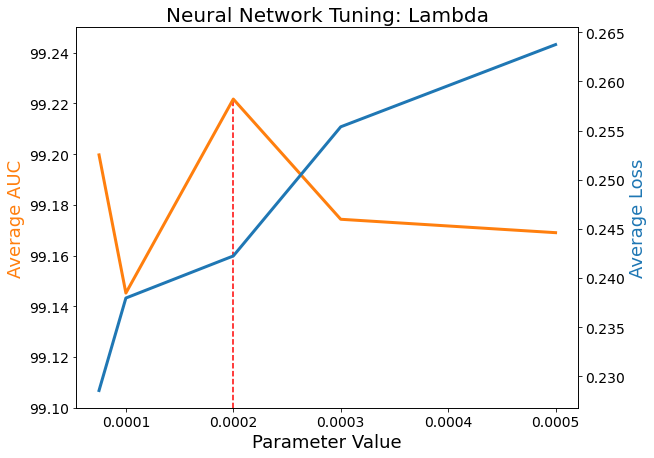

In [ ]:
print(auc_cv_vals, loss_cv_vals)
results = pd.DataFrame({'vals':param_rng,'auc':auc_cv_vals,'loss': loss_cv_vals})
print(results)

results = results.iloc[1:,:]
with mpl.style.context('seaborn-muted'):
  fig, ax1 = plt.subplots(figsize=(9,7))
  ax1.plot(results.vals, results.auc,
           lw=3, c='#FF7F0E', label='AUC')
  ax2 = ax1.twinx()
  ax2.plot(results.vals, results.loss,
           lw=3, color='#1F77B4', label='AUC')
  ax1.set_xlabel('Parameter Value');
  ax1.set_ylabel('Average AUC', color='#FF7F0E')
  ax2.set_ylabel('Average Loss',color='#1F77B4')
  ax1.vlines(0.0002, ymin=98.52, ymax=max(results.auc),
             linestyles='dashed',colors='r')
  ax1.set_ylim([99.1,99.25])
  plt.title('Neural Network Tuning: Lambda');

### Tuning batch size

In [ ]:
# WDS8
learning_rate = 0.01
weight_reg = 2e-4

In [ ]:
auc_cv_vals = []
loss_cv_vals = []
param_rng = [50,75,100,125,150]
for bs in param_rng:

  print(f"****Trying parameter value: {bs}****")

  # Define per-fold score containers
  auc_per_fold = []
  loss_per_fold = []

  optimizer = Adam(learning_rate = learning_rate)

  # maintain stratified sampling
  kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=3, random_state=seed)

  # Stratified K-fold Cross Validation model evaluation
  fold_no = 1

  for train, test in kfold.split(Xtrsc, yenc_trn):

    # Define model architecture
    model = tfk.Sequential([
        tfk.layers.Dense(len(incols), 
                        activation="relu", 
                        use_bias=True,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(weight_reg),
                        input_shape=(len(incols),), 
                        name="dense_1"),
        tfk.layers.Dropout(drop_rate, name="dropout_1"),
        tfk.layers.Dense(len(incols),
                        activation="relu",
                        use_bias=True,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(weight_reg),
                        name="dense_2"),
        tfk.layers.Dropout(drop_rate, name="dropout_2"),
        tfk.layers.Dense(len(code2label), activation='softmax', name="output") # Output layer
      ], name="model")
    
    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss=loss_function,
                  metrics=tfk.metrics.AUC(curve='ROC', multi_label=False))
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.fit(x=Xtrsc.iloc[train,:],
                        y=yc_oh_train[train],
                        batch_size=bs,
                        epochs=n_epochs,
                        validation_data=(Xvlsc,yc_oh_val),
                        verbose=verbosity)
    
    # Generate generalization metrics
    scores = model.evaluate(Xtrsc.iloc[test,:], yc_oh_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    auc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
  # Provide average scores
  auc_cv_vals.append(np.mean(auc_per_fold))
  loss_cv_vals.append(np.mean(loss_per_fold))


Streaming output truncated to the last 5000 lines.
23/23 [==============================] - 0s 6ms/step - loss: 0.3741 - auc_305: 0.9796 - val_loss: 0.3097 - val_auc_305: 0.9877
Epoch 38/100
23/23 [==============================] - 0s 7ms/step - loss: 0.3553 - auc_305: 0.9823 - val_loss: 0.3131 - val_auc_305: 0.9870
Epoch 39/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3585 - auc_305: 0.9818 - val_loss: 0.2947 - val_auc_305: 0.9890
Epoch 40/100
23/23 [==============================] - 0s 7ms/step - loss: 0.3548 - auc_305: 0.9823 - val_loss: 0.3145 - val_auc_305: 0.9868
Epoch 41/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3639 - auc_305: 0.9809 - val_loss: 0.3202 - val_auc_305: 0.9868
Epoch 42/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3584 - auc_305: 0.9819 - val_loss: 0.3099 - val_auc_305: 0.9869
Epoch 43/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3536 - auc_305: 0.9825 - val_loss: 0.3220 - va

[98.86327096062861, 98.94972054613453, 99.02564493630867, 99.02050149179749, 99.02296001855613] [0.29408041815792196, 0.28067255175242595, 0.27028534197301524, 0.27133149902375175, 0.26895722516054116]
   vals        auc      loss
0    50  98.863271  0.294080
1    75  98.949721  0.280673
2   100  99.025645  0.270285
3   125  99.020501  0.271331
4   150  99.022960  0.268957


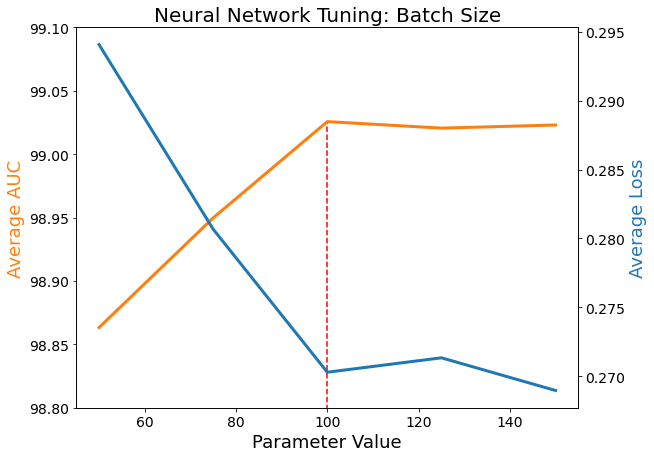

In [ ]:
print(auc_cv_vals, loss_cv_vals)
results = pd.DataFrame({'vals':param_rng,'auc':auc_cv_vals,'loss': loss_cv_vals})
print(results)

with mpl.style.context('seaborn-muted'):
  fig, ax1 = plt.subplots(figsize=(9,7))
  ax1.plot(results.vals, results.auc,
           lw=3, c='#FF7F0E', label='AUC')
  ax2 = ax1.twinx()
  ax2.plot(results.vals, results.loss,
           lw=3, color='#1F77B4', label='AUC')
  ax1.set_xlabel('Parameter Value');
  ax1.set_ylabel('Average AUC', color='#FF7F0E')
  ax2.set_ylabel('Average Loss',color='#1F77B4')
  ax1.vlines(100, ymin=95, ymax=max(results.auc),
            linestyles='dashed',colors='r')
  ax1.set_ylim([98.8,99.1])
  plt.title('Neural Network Tuning: Batch Size');

### Tuning drop_rate

In [ ]:
# WDS8
learning_rate = 0.01
weight_reg = 2e-4
batch_size = 100

In [ ]:
auc_cv_vals = []
loss_cv_vals = []
param_rng = [0.0,0.1,0.2,0.3,0.4,0.5]
for dr in param_rng:

  print(f"****Trying parameter value: {dr}****")

  # Define per-fold score containers
  auc_per_fold = []
  loss_per_fold = []

  optimizer = Adam(learning_rate = learning_rate)

  # maintain stratified sampling
  kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=3, random_state=seed)

  # Stratified K-fold Cross Validation model evaluation
  fold_no = 1

  for train, test in kfold.split(Xtrsc, yenc_trn):

    # Define model architecture
    model = tfk.Sequential([
        tfk.layers.Dense(len(incols), 
                        activation="relu", 
                        use_bias=True,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(weight_reg),
                        input_shape=(len(incols),), 
                        name="dense_1"),
        tfk.layers.Dropout(dr, name="dropout_1"),
        tfk.layers.Dense(len(incols),
                        activation="relu",
                        use_bias=True,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(weight_reg),
                        name="dense_2"),
        tfk.layers.Dropout(dr, name="dropout_2"),
        tfk.layers.Dense(len(code2label), activation='softmax', name="output") # Output layer
      ], name="model")
    
    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss=loss_function,
                  metrics=tfk.metrics.AUC(curve='ROC', multi_label=False))
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.fit(x=Xtrsc.iloc[train,:],
                        y=yc_oh_train[train],
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_data=(Xvlsc,yc_oh_val),
                        verbose=verbosity)
    
    # Generate generalization metrics
    scores = model.evaluate(Xtrsc.iloc[test,:], yc_oh_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    auc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
  # Provide average scores
  auc_cv_vals.append(np.mean(auc_per_fold))
  loss_cv_vals.append(np.mean(loss_per_fold))


Streaming output truncated to the last 5000 lines.
34/34 [==============================] - 0s 5ms/step - loss: 0.6182 - auc_485: 0.9395 - val_loss: 0.5062 - val_auc_485: 0.9617
Epoch 38/100
34/34 [==============================] - 0s 5ms/step - loss: 0.6141 - auc_485: 0.9409 - val_loss: 0.4985 - val_auc_485: 0.9623
Epoch 39/100
34/34 [==============================] - 0s 5ms/step - loss: 0.6266 - auc_485: 0.9381 - val_loss: 0.4976 - val_auc_485: 0.9627
Epoch 40/100
34/34 [==============================] - 0s 5ms/step - loss: 0.6125 - auc_485: 0.9421 - val_loss: 0.5104 - val_auc_485: 0.9612
Epoch 41/100
34/34 [==============================] - 0s 5ms/step - loss: 0.6105 - auc_485: 0.9407 - val_loss: 0.4874 - val_auc_485: 0.9652
Epoch 42/100
34/34 [==============================] - 0s 5ms/step - loss: 0.6014 - auc_485: 0.9436 - val_loss: 0.5002 - val_auc_485: 0.9627
Epoch 43/100
34/34 [==============================] - 0s 5ms/step - loss: 0.6202 - auc_485: 0.9413 - val_loss: 0.4915 - va

[99.06676468999527, 99.23241934920136, 98.99539592210245, 98.71084627336592, 98.41051280340363, 97.83228637428073] [0.25953229502007785, 0.24385062008537084, 0.2728369358731767, 0.3052342286745403, 0.3378297873107555, 0.3942630662206527]
   vals        auc      loss
0   0.0  99.066765  0.259532
1   0.1  99.232419  0.243851
2   0.2  98.995396  0.272837
3   0.3  98.710846  0.305234
4   0.4  98.410513  0.337830
5   0.5  97.832286  0.394263


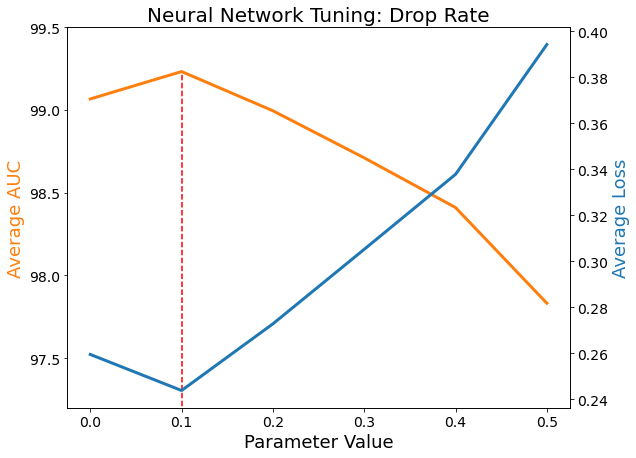

In [ ]:
print(auc_cv_vals, loss_cv_vals)
results = pd.DataFrame({'vals':param_rng,'auc':auc_cv_vals,'loss': loss_cv_vals})
print(results)

with mpl.style.context('seaborn-muted'):
  fig, ax1 = plt.subplots(figsize=(9,7))
  ax1.plot(results.vals, results.auc,
           lw=3, c='#FF7F0E', label='AUC')
  ax2 = ax1.twinx()
  ax2.plot(results.vals, results.loss,
           lw=3, color='#1F77B4', label='AUC')
  ax1.set_xlabel('Parameter Value');
  ax1.set_ylabel('Average AUC', color='#FF7F0E')
  ax2.set_ylabel('Average Loss',color='#1F77B4')
  ax1.vlines(0.10, ymin=95, ymax=max(results.auc),
             linestyles='dashed',colors='r')
  ax1.set_ylim([97.2,99.5])
  plt.title('Neural Network Tuning: Drop Rate');

### Train Complete Model

In [ ]:
# WDS8
learning_rate = 0.01
weight_reg = 2e-4
batch_size = 100
drop_rate = 0.1
n_epochs = 150

In [ ]:
optimizer = Adam(learning_rate = learning_rate)

# Define model architecture
model2 = tfk.Sequential([
    tfk.layers.Dense(len(incols), 
                    activation="relu", 
                    use_bias=True,
                    kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(weight_reg),
                    input_shape=(len(incols),), 
                    name="dense_1"),
    tfk.layers.Dropout(drop_rate, name="dropout_1"),
    tfk.layers.Dense(len(incols),
                    activation="relu",
                    use_bias=True,
                    kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(weight_reg),
                    name="dense_2"),
    tfk.layers.Dropout(drop_rate, name="dropout_2"),
    tfk.layers.Dense(len(code2label), activation='softmax', name="output") # Output layer
  ], name="model2")
    
# Compile the model
model2.compile(optimizer=optimizer, 
              loss=loss_function,
              metrics=tfk.metrics.AUC(curve='ROC', multi_label=False))

history = model2.fit(x=Xtrsc,
                    y=yc_oh_train,
                    batch_size=batch_size,
                    epochs=n_epochs,
                    validation_data=(Xvlsc,yc_oh_val),
                    verbose=verbosity)

Epoch 1/150
38/38 [==============================] - 1s 12ms/step - loss: 1.0209 - auc_510: 0.8236 - val_loss: 0.7257 - val_auc_510: 0.9155
Epoch 2/150
38/38 [==============================] - 0s 5ms/step - loss: 0.6528 - auc_510: 0.9306 - val_loss: 0.6136 - val_auc_510: 0.9392
Epoch 3/150
38/38 [==============================] - 0s 4ms/step - loss: 0.5679 - auc_510: 0.9478 - val_loss: 0.4887 - val_auc_510: 0.9630
Epoch 4/150
38/38 [==============================] - 0s 4ms/step - loss: 0.4971 - auc_510: 0.9602 - val_loss: 0.4392 - val_auc_510: 0.9707
Epoch 5/150
38/38 [==============================] - 0s 4ms/step - loss: 0.4635 - auc_510: 0.9656 - val_loss: 0.4206 - val_auc_510: 0.9725
Epoch 6/150
38/38 [==============================] - 0s 4ms/step - loss: 0.4214 - auc_510: 0.9718 - val_loss: 0.3941 - val_auc_510: 0.9758
Epoch 7/150
38/38 [==============================] - 0s 4ms/step - loss: 0.4123 - auc_510: 0.9729 - val_loss: 0.3541 - val_auc_510: 0.9815
Epoch 8/150
38/38 [=======

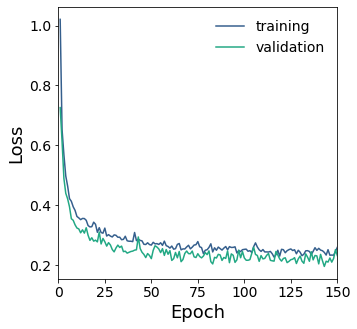

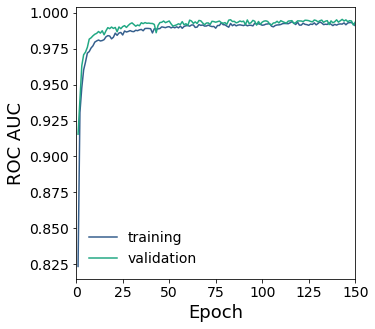

In [ ]:
# Plot the training session

with mpl.style.context('seaborn-muted'):
  fig = plt.figure(figsize=(5,5))
  fig.tight_layout()
  plt.xlim(0, np.round(len(history.epoch)+4,-1))
  #plt.ylim(0.0, 0.5)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.plot(list(map(lambda x: x + 1, history.epoch)), history.history["loss"],     label="training",   color=plt.cm.viridis(0.3))
  plt.plot(list(map(lambda x: x + 1, history.epoch)), history.history["val_loss"], label="validation", color=plt.cm.viridis(0.6))
  plt.legend(frameon=False, loc=0)
  #plt.savefig(datafolder / 'Fig-ANN-trainingloss.png',transparent=False,orientation='landscape',bbox_inches='tight')
  plt.show()

  fig = plt.figure(figsize=(5,5))
  fig.tight_layout()
  plt.xlim(0, np.round(len(history.epoch)+4,-1))
  #plt.ylim(0.0, 0.5)
  plt.xlabel("Epoch")
  plt.ylabel("ROC AUC")
  plt.plot(list(map(lambda x: x + 1, history.epoch)), history.history['auc_510'],     label="training",   color=plt.cm.viridis(0.3))
  plt.plot(list(map(lambda x: x + 1, history.epoch)), history.history['val_auc_510'], label="validation", color=plt.cm.viridis(0.6))
  plt.legend(frameon=False, loc=0)
  #plt.savefig(datafolder / 'Fig-ANN-trainingauc.png',transparent=False,orientation='landscape',bbox_inches='tight')
  plt.show()

In [ ]:
# evaluate the model
metric = tf.keras.metrics.CategoricalAccuracy()
labels = model2.predict(Xtrsc)
metric.update_state(yc_oh_train,labels)
print('Train: accuracy, loss, auc:',metric.result().numpy(), model2.evaluate(Xtrsc, yc_oh_train, verbose=True))

labels = model2.predict(Xvlsc)
metric.update_state(yc_oh_val,labels)
print('Validate: accuracy, loss, auc:',metric.result().numpy(), model2.evaluate(Xvlsc, yc_oh_val, verbose=True))

labels = model2.predict(Xtssc)
metric.update_state(yc_oh_test,labels)
print('Test: accuracy, loss, auc:',metric.result().numpy(), model2.evaluate(Xtssc, yc_oh_test, verbose=True))

117/117 [==============================] - 0s 1ms/step - loss: 0.1684 - auc_510: 0.9977
Train: accuracy, loss, auc: 0.953475935828877 [0.16840864718127094, 0.9977093640081215]
26/26 [==============================] - 0s 2ms/step - loss: 0.2308 - auc_510: 0.9934
Validate: accuracy, loss, auc: 0.9502421840598855 [0.23077520579137675, 0.9933631735291863]
26/26 [==============================] - 0s 2ms/step - loss: 0.2435 - auc_510: 0.9923
Test: accuracy, loss, auc: 0.9472305389221557 [0.24354958909440907, 0.9922826454230176]


confusion matrix:
[[ 20   7   1   0]
 [  1 125   9   1]
 [  0  10 285   9]
 [  0   0  18 316]]

              precision    recall  f1-score   support

       No-GT       0.95      0.71      0.82        28
      Low-GT       0.88      0.92      0.90       136
      Med-GT       0.91      0.94      0.92       304
     High-GT       0.97      0.95      0.96       334

    accuracy                           0.93       802
   macro avg       0.93      0.88      0.90       802
weighted avg       0.93      0.93      0.93       802



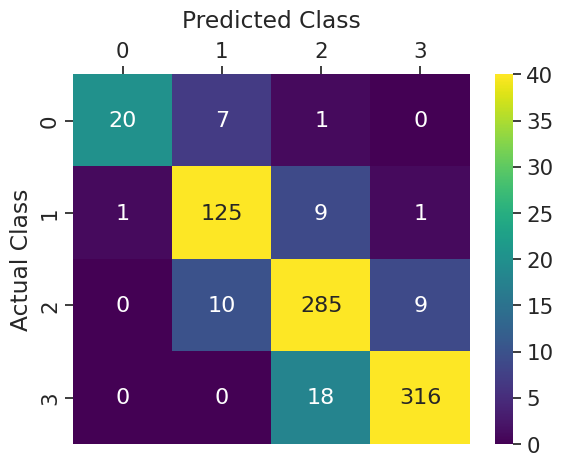

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

pred = np.argmax(model2.predict(Xtssc),axis=1)

# print confusion matrix
confusion = confusion_matrix(yenc_tst, pred)
print('confusion matrix:\n{}\n'.format(confusion))
print(classification_report(yenc_tst, pred, target_names=['No-GT','Low-GT','Med-GT','High-GT']))

with mpl.style.context('default'):
  df_cm = pd.DataFrame(confusion, range(4), range(4))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, cmap='viridis',vmax=40,annot=True, 
              fmt='g', annot_kws={"size": 16}) # font size
  plt.xlabel('Predicted Class',labelpad=10)
  ax = plt.gca()
  ax.xaxis.set_label_position('top') 
  plt.ylabel('Actual Class',labelpad=5)
  ax.xaxis.tick_top()
  ax.yaxis.tick_left()
  plt.savefig(datafolder / 'NeuralNetwork_WDS8_ConfusionMatrix.png', bbox_inches='tight')
  plt.show()

26/26 [==============================] - 0s 2ms/step - loss: 0.2435 - auc_510: 0.9923


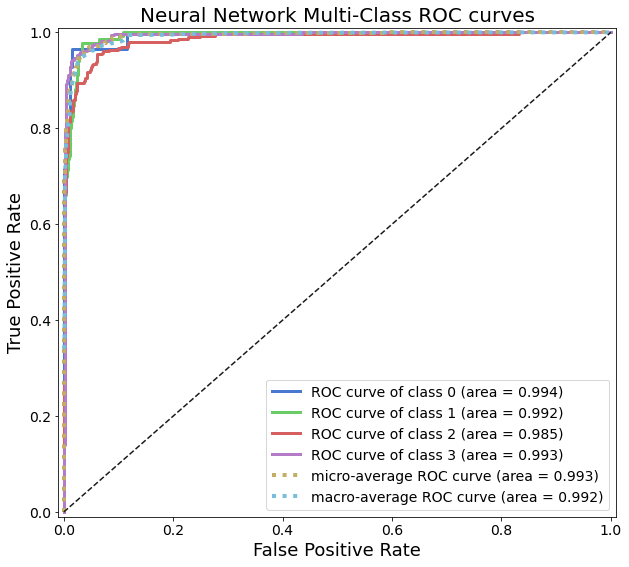

In [ ]:
## from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#area-under-roc-for-the-multiclass-problem
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from itertools import cycle
import matplotlib as mpl

# calculate previous model test results
pred_probs_test = model2.predict(Xtssc)
preds_test = np.argmax(pred_probs_test,axis=1)

#probs = model2.predict(Xtssc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes=[0,1,2,3]
n_classes = len(classes)
yt_bin = yc_oh_test
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yt_bin[:,i], pred_probs_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yt_bin.ravel(), pred_probs_test.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc['macro'] = model2.evaluate(Xtssc, yc_oh_test)[1]
#roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 3
with mpl.style.context("seaborn-muted"):
  plt.figure(figsize=(10,9))

  colors = cycle(['#4A67BF','#8C8C8C','#73A96C','#AD5153'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], lw=lw,   #color=color,lw=lw,alpha=.5,
              label='ROC curve of class {0} (area = {1:0.3f})'
              ''.format(i, roc_auc[i]))
      
  plt.plot(fpr["micro"], tpr["micro"],
           label='micro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["micro"]),
           linestyle=':', lw=(lw+1))  #color='#C98AC1',alpha=.5

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
           linestyle=':', lw=(lw+1))  #color='#82B3CC', lw=lw,alpha=.5

  plt.plot([0, 1], [0, 1], 'k--') #, lw=lw, alpha=0.5
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Neural Network Multi-Class ROC curves')
  plt.legend(loc="lower right")
  plt.savefig(datafolder / 'NeuralNetwork_WDS8_ROCplot.png', bbox_inches='tight')
  plt.show()

## Load full dataset and predict

In [ ]:
with open(datafolder/ "full_shared.pkl","rb") as handle: 
    fulldatadict = pkl.load(handle)
    
# unpack
FULLdf = fulldatadict['data']
FULLcoords = fulldatadict['coords']

pfa_result = FULLdf['GeothermGrad_4class']

# drop unnecessary columns
FULLdf = FULLdf[incols]

# scale and transform the data to match the training data
FULLdfsc = pd.DataFrame(pl.transform(FULLdf), columns=colnames)

# use all data
Xallsc = pd.concat([Xtrsc[colnames],Xvlsc[colnames],Xtssc[colnames]])
yc_oh_all=np.vstack((yc_oh_train,yc_oh_val,yc_oh_test))

#### train neural network on ALL data

In [ ]:
optimizer = Adam(learning_rate = learning_rate)

# Define model architecture
modelall = tfk.Sequential([
    tfk.layers.Dense(len(incols), 
                    activation="relu", 
                    use_bias=True,
                    kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(weight_reg),
                    input_shape=(len(incols),), 
                    name="HiddenLayer1"),
    tfk.layers.Dropout(drop_rate, name="Dropout1"),
    tfk.layers.Dense(len(incols),
                    activation="relu",
                    use_bias=True,
                    kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(weight_reg),
                    name="HiddenLayer2"),
    tfk.layers.Dropout(drop_rate, name="Dropout2"),
    tfk.layers.Dense(len(code2label), activation='softmax', name="OutputLayer") # Output layer
  ], name="Final_NN_Model")
    
# Compile the model
modelall.compile(optimizer=optimizer, 
              loss=loss_function,
              metrics=tfk.metrics.AUC(curve='ROC', multi_label=False))

history = modelall.fit(x=Xallsc,
                      y=yc_oh_all,
                      batch_size=batch_size,
                      epochs=n_epochs,
                      verbose=verbosity)

Epoch 1/150
54/54 [==============================] - 1s 3ms/step - loss: 0.9148 - auc_511: 0.8599
Epoch 2/150
54/54 [==============================] - 0s 3ms/step - loss: 0.6164 - auc_511: 0.9386
Epoch 3/150
54/54 [==============================] - 0s 3ms/step - loss: 0.5187 - auc_511: 0.9570
Epoch 4/150
54/54 [==============================] - 0s 3ms/step - loss: 0.4693 - auc_511: 0.9651
Epoch 5/150
54/54 [==============================] - 0s 3ms/step - loss: 0.4489 - auc_511: 0.9679
Epoch 6/150
54/54 [==============================] - 0s 3ms/step - loss: 0.4199 - auc_511: 0.9720
Epoch 7/150
54/54 [==============================] - 0s 3ms/step - loss: 0.4014 - auc_511: 0.9747
Epoch 8/150
54/54 [==============================] - 0s 3ms/step - loss: 0.3930 - auc_511: 0.9757
Epoch 9/150
54/54 [==============================] - 0s 3ms/step - loss: 0.3881 - auc_511: 0.9766
Epoch 10/150
54/54 [==============================] - 0s 3ms/step - loss: 0.3592 - auc_511: 0.9802
Epoch 11/150
54/54 

In [ ]:
# predict result
FULL_ypred_proba = modelall.predict(FULLdfsc)
FULL_ypred = np.argmax(FULL_ypred_proba, axis=-1)
FULL_ypred

array([3, 3, 3, ..., 1, 1, 1])

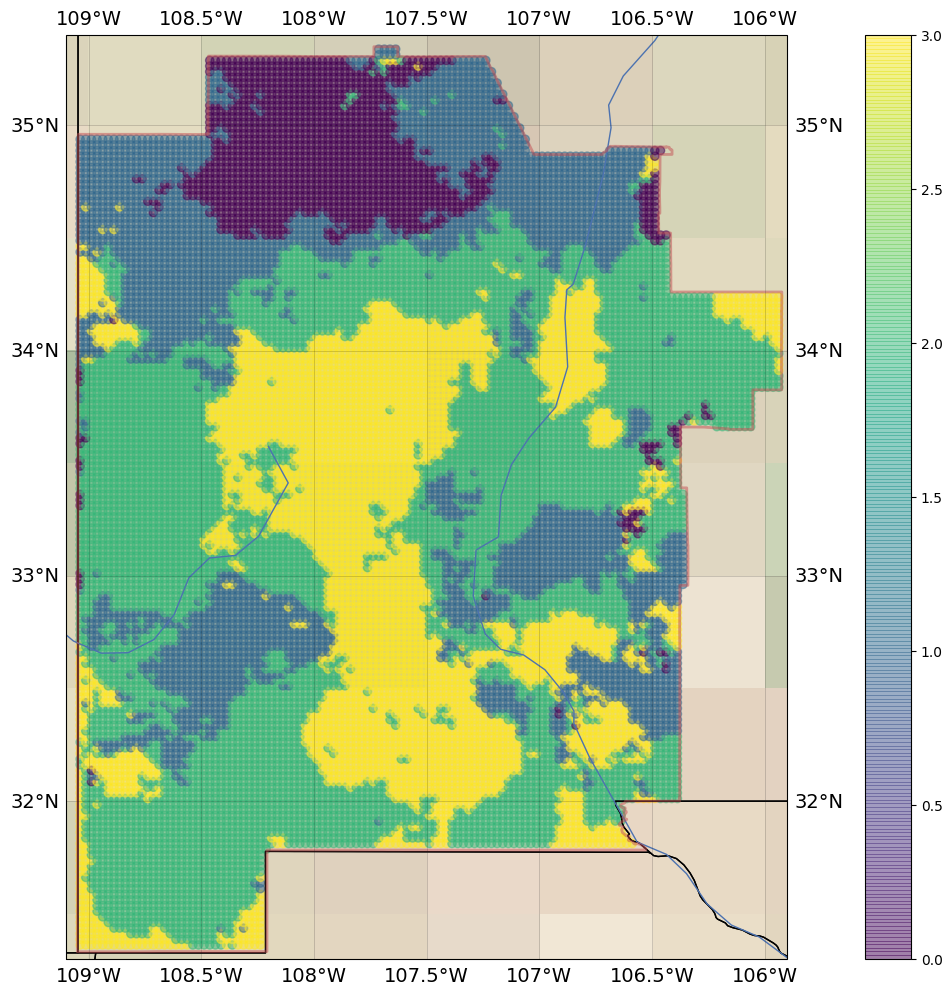

In [ ]:
with mpl.style.context('default'):
  ax = createBasemap();
  gdf = gpd.GeoDataFrame(FULLcoords, 
                        geometry=gpd.points_from_xy(FULLcoords.Longitude, FULLcoords.Latitude),
                        crs = {'init': 'epsg:4326'})
  pc = ax.scatter(FULLcoords.Longitude,
                  FULLcoords.Latitude,
                  cmap='viridis',
                  c=FULL_ypred,
                  alpha=0.5,
                  transform=myprojection);
  plt.colorbar(pc);
  #plt.savefig(datafolder / 'neuralnetwork_model_prediction_map.png')
  #plt.savefig(datafolder / 'neuralnetwork_model_prediction_map.pdf')

In [ ]:
# save out for use in other scripts
shared = {
          "coords":FULLcoords,
          "model":None,
          "full_dataset":FULLdf,
          "selected_columns":Xtrsc.columns,
          "test_yc_pred":preds_test,
          "test_yc_pred_proba":pred_probs_test,
          "full_yc_pred":FULL_ypred,
          "full_yc_pred_proba":FULL_ypred_proba
         }
#with open(datafolder / "gradient_class_prediction_ann.pkl","wb") as handle:
#    pkl.dump(shared, handle, protocol=pkl.HIGHEST_PROTOCOL)

#modelall.save_weights(datafolder / 'ann_WDS4_weights.sav')
#modelall.save(datafolder / 'ann_WDS4_fullmodel.sav')

### make plot of neural network

In [ ]:
layers = [24, 24, 24, 4]

layers_str = ["Input"] + ["Hidden"] * (len(layers) - 2) + ["Output"]
layers_col = ["none"] + ["none"] * (len(layers) - 2) + ["none"]
layers_fill = ["black"] + ["gray"] * (len(layers) - 2) + ["black"]

penwidth = 15
font = "Hilda 10"

print("digraph G {")
print("\tfontname = \"{}\"".format(font))
print("\trankdir=LR")
print("\tsplines=line")
print("\tnodesep=.08;")
print("\tranksep=1;")
print("\tedge [color=black, arrowsize=.5];")
print("\tnode [fixedsize=true,label=\"\",style=filled," + \
    "color=none,fillcolor=gray,shape=circle]\n")

# Clusters
for i in range(0, len(layers)):
    print(("\tsubgraph cluster_{} {{".format(i)))
    print(("\t\tcolor={};".format(layers_col[i])))
    print(("\t\tnode [style=filled, color=white, penwidth={},"
          "fillcolor={} shape=circle];".format(
              penwidth,
              layers_fill[i])))

    print(("\t\t"), end=' ')

    for a in range(layers[i]):
        print("l{}{} ".format(i + 1, a), end=' ')

    print(";")
    print(("\t\tlabel = {};".format(layers_str[i])))

    print("\t}\n")

# Nodes
for i in range(1, len(layers)):
    for a in range(layers[i - 1]):
        for b in range(layers[i]):
            print("\tl{}{} -> l{}{}".format(i, a, i + 1, b))

print("}")

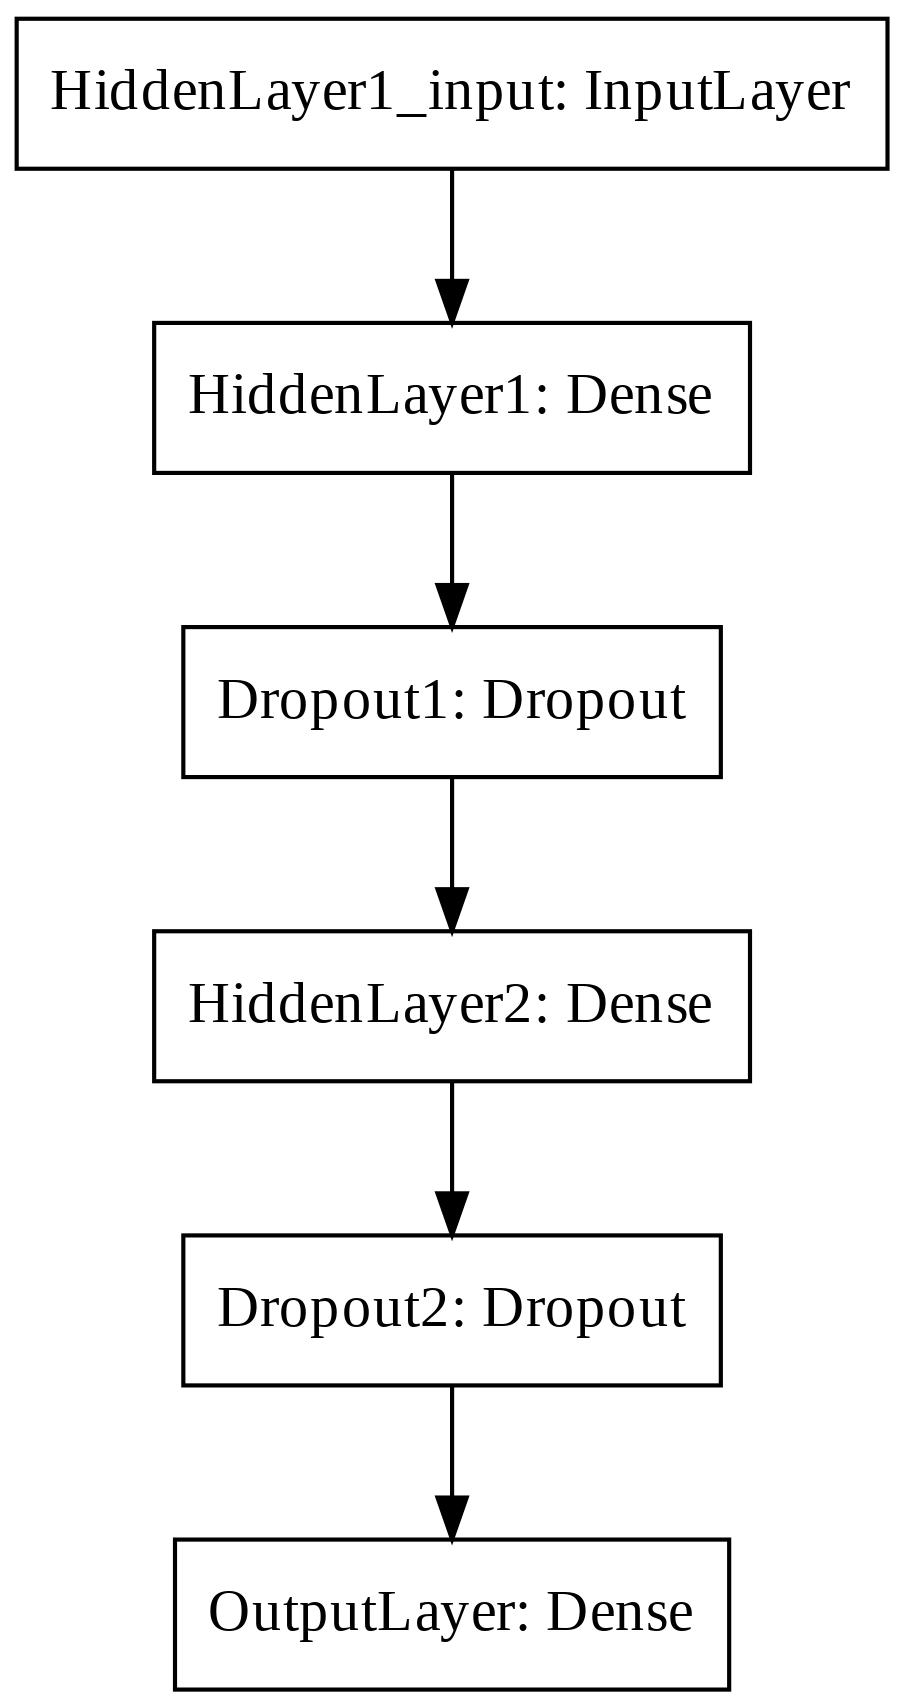

In [ ]:
tf.keras.utils.plot_model(modelall,to_file=datafolder / 'Figure-TF_ANN_plot.png',show_shapes=False,dpi=300,show_layer_names=True)